# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import random
import shutil
import glob
import yaml
import torch
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import cv2

from PIL import Image
from matplotlib import pyplot as plt
from matplotlib import patches
from pathlib import Path
from sklearn.model_selection import train_test_split

# Install YOLOv8

In [2]:
%pip install ultralytics

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.7/616.7 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.9/614.9 kB 21.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 614.4/614.4 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.9/606.9 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.2/606.2 kB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.5/605.5 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.6/605.6 kB 26.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 19.6 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.5.4.60
    Uninstalling opencv-python-4.5.4.60:
      Successfully uninstalled opencv-python-4.5.4.60
Note: you may need to restart the kernel to use updated packages.

In [3]:
import ultralytics
from ultralytics import YOLO
ultralytics.checks()

Ultralytics YOLOv8.0.145 🚀 Python-3.7.12 torch-1.12.0 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5597.8/8062.4 GB disk)


# Create Directory

## **Name of our dataset!!** <br>
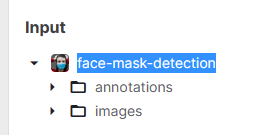

In [4]:
directory = "/kaggle/input/face-mask-detection" # directory dataset
image_directory = directory + "/images" # Don't forget to look at the name of the folder where his photos are stored. As in the picture above, in the name images we type /images.
annotation_directory = directory + "/annotations" # Don't forget to look at the name of the annotate folder. As in the picture above, in the name of annotations, we type /annotations.
annotations = list(Path(annotation_directory).glob(r'**/*{}'.format('xml')))

# Data Preprocessing

In [5]:
# This class_id is also important. We have to declare class for labels by id. Let's type it in here and go down.
class_id = {
    "with_mask" : 0,
    "mask_weared_incorrect" : 1,
    "without_mask" : 2
}

data_dict = {
    'filename': [],
    'label': [],
    'class_id': [],
    'width': [],
    'height': [],
    'bboxes': []
}
for annotation_path in annotations:
    tree = ET.parse(annotation_path)
    root = tree.getroot()
    filename = root.find('filename').text
    for obj in root.findall("object"):
        label = obj.find("name").text
        
        bbox = []
        # bndbox has xmin, ymin, xmax, ymax
        bndbox_tree = obj.find('bndbox')
        bbox.append(int(bndbox_tree.find('xmin').text))
        bbox.append(int(bndbox_tree.find('ymin').text))
        bbox.append(int(bndbox_tree.find('xmax').text))
        bbox.append(int(bndbox_tree.find('ymax').text))
        size = root.find('size')
        
        data_dict['filename'].append(filename)
        data_dict['width'].append(int(size.find('width').text))
        data_dict['height'].append(int(size.find('height').text))
        data_dict['label'].append(label)
        data_dict['class_id'].append(class_id[label])
        data_dict['bboxes'].append(bbox)

df_data = pd.DataFrame(data_dict)

df_data.head()

filename                  label  class_id  width  height  \
0  maksssksksss737.png              with_mask         0    400     226   
1  maksssksksss737.png              with_mask         0    400     226   
2  maksssksksss737.png  mask_weared_incorrect         1    400     226   
3  maksssksksss737.png              with_mask         0    400     226   
4  maksssksksss737.png              with_mask         0    400     226   

               bboxes  
0    [28, 55, 46, 71]  
1   [98, 62, 111, 78]  
2  [159, 50, 193, 90]  
3  [293, 59, 313, 80]  
4  [352, 51, 372, 72]

In [6]:
df_data.isna().sum() # Check the null value

filename    0
label       0
class_id    0
width       0
height      0
bboxes      0
dtype: int64

In [7]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4072 entries, 0 to 4071
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  4072 non-null   object
 1   label     4072 non-null   object
 2   class_id  4072 non-null   int64 
 3   width     4072 non-null   int64 
 4   height    4072 non-null   int64 
 5   bboxes    4072 non-null   object
dtypes: int64(3), object(3)
memory usage: 191.0+ KB


In [8]:
df_data.label.unique() # Class names of labels

array(['with_mask', 'mask_weared_incorrect', 'without_mask'], dtype=object)

In [9]:
print(f"Total 'without_mask' labels: {sum(df_data.label == 'without_mask')}")
print(f"Total 'mask_weared_incorrect' labels: {sum(df_data.label == 'mask_weared_incorrect')}")
print(f"Total 'with_mask' labels: {sum(df_data.label == 'with_mask')}")

Total 'without_mask' labels: 717
Total 'mask_weared_incorrect' labels: 123
Total 'with_mask' labels: 3232


# Visualize Data
> Let's take a look at what our Dataset looks like!

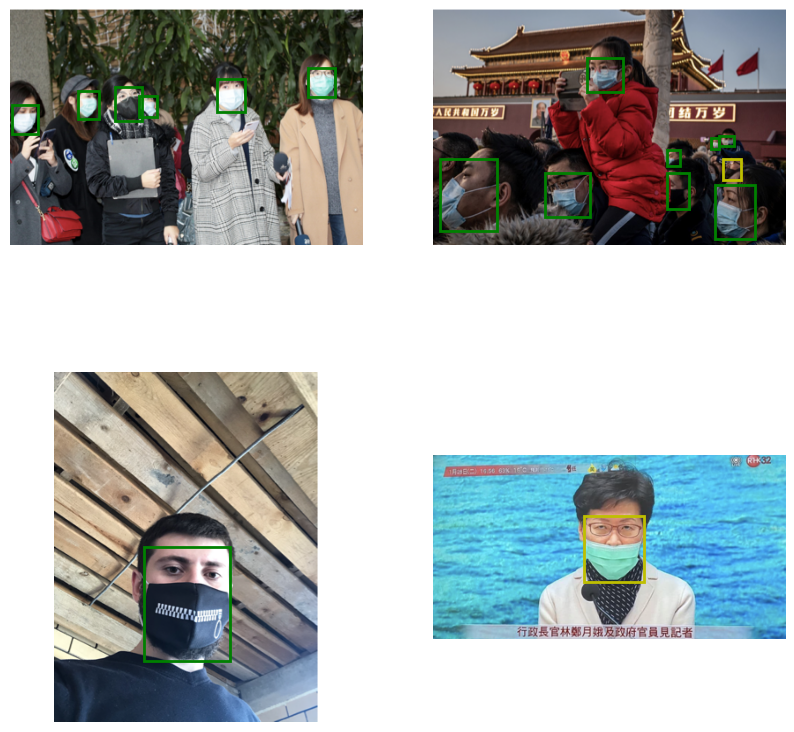

In [10]:
def show_random_images_with_bbox(df):
    all_images = os.listdir(image_directory)
    random_image_filename = random.sample(all_images, 4)
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))
    for i, filename in enumerate(random_image_filename):
        selected_df = df[df['filename'] == filename]
        
        image = Image.open(image_directory + '/' + filename)
        
        ax.flat[i].imshow(image)
        ax.flat[i].axis(False)
        
        image_bboxes = []
        for df_index in range(0, len(selected_df)):
            color = "g"
            if selected_df.iloc[df_index].class_id == 1: color = "y"
            elif selected_df.iloc[df_index].class_id == 2: color = "r"
            
            x_min, y_min, x_max, y_max = selected_df.iloc[df_index].bboxes
            
            rect = patches.Rectangle([x_min, y_min], x_max-x_min, y_max-y_min, 
                             linewidth=2, edgecolor=color, facecolor="none")
            ax.flat[i].add_patch(rect)
            
show_random_images_with_bbox(df_data)

In [11]:
# we need to convert our bbox format to yolo as the current one that we have is on pascal_voc
def pascal_voc_to_yolo_bbox(bbox_array, w, h):
    x_min, y_min, x_max, y_max = bbox_array
    
    x_center = ((x_max + x_min) / 2) / w
    y_center = ((y_max + y_min) / 2) / h
    
    width = (x_max - x_min) / w
    height = (y_max - y_min) / h
    
    return [x_center, y_center, width, height]

# Split Train, Val, Test images
> **Divide the dataset into Train, Validation, Test.**

In [12]:
train_path = "/kaggle/working/datasets/train"
valid_path = "/kaggle/working/datasets/valid"
test_path = "/kaggle/working/datasets/test"

os.mkdir("/kaggle/working/datasets")
os.mkdir(train_path)
os.mkdir(valid_path)
os.mkdir(test_path)

We need to move our respective images to its folder and create label file for our image to use in YOLOv8

In [13]:
random_state = 42 
 
train, test = train_test_split(df_data.filename.unique(), test_size=0.1, random_state=random_state)
train, valid = train_test_split(train, test_size=0.2, random_state=random_state)

def copy_image_file(image_items, folder_name):
    for image in image_items:
            image_path = image_directory + "/" + image
            new_image_path = os.path.join(folder_name, image)
            shutil.copy(image_path, new_image_path)

def create_label_file(image_items, folder_name):
    for image in image_items:
        fileName = Path(image).stem
        df = df_data[df_data['filename'] == image]
        with open(folder_name + "/" + fileName +'.txt', 'w') as f:
            for i in range(0, len(df)):
                bbox = pascal_voc_to_yolo_bbox(df.iloc[i]['bboxes'], df.iloc[i]['width'], df.iloc[i]['height'])
                bbox_text = " ".join(map(str, bbox))
                txt = str(df.iloc[i]['class_id'])+ " " + bbox_text
                f.write(txt)
                if i != len(df) - 1:
                    f.write("\n")
                

copy_image_file(train, train_path)
copy_image_file(valid, valid_path)
copy_image_file(test, test_path)

create_label_file(train, train_path)
create_label_file(valid, valid_path)
create_label_file(test, test_path)

In [14]:
def walk_through_dir(filepath):
    for dirpath, dirnames, filenames in os.walk(filepath):
        print(f"There are {len(dirnames)} directories and {len(glob.glob(filepath + '/*.png', recursive = True))} images in '{dirpath}'.")
    
walk_through_dir(train_path)
walk_through_dir(valid_path)  
walk_through_dir(test_path)  

There are 0 directories and 613 images in '/kaggle/working/datasets/train'.
There are 0 directories and 154 images in '/kaggle/working/datasets/valid'.
There are 0 directories and 86 images in '/kaggle/working/datasets/test'.


# Create YAML file

In [15]:
classes = list(df_data.label.unique())
class_count = len(classes)
train_config_yaml = f"""
    train: train
    val: valid
    test: test
    nc: {class_count}
    names:
        0 : with_mask
        1 : mask_weared_incorrect
        2 : without_mask
    """                                     # Don't forget to convert the class in here to be the same as the one above that we set.

with open('train_config.yaml', 'w') as f:
    f.write(train_config_yaml)
    
%cat train_config.yaml

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)

    train: train
    val: valid
    test: test
    nc: 3
    names:
        0 : with_mask
        1 : mask_weared_incorrect
        2 : without_mask
    

# Train

<img src="https://raw.githubusercontent.com/ultralytics/assets/main/yolov8/yolo-comparison-plots.png" width="70%"></img>

In [16]:
model = YOLO("yolov8n.pt") # You can choose the yolo version here, it's up to you which one you want. Here i choose
model.train(data="train_config.yaml", epochs=100) # กำหนดได้ว่าให้ train กี่ครั้ง ตรง epochs=

  0%|          | 0.00/6.23M [00:00<?, ?B/s]

New https://pypi.org/project/ultralytics/8.2.11 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.145 🚀 Python-3.7.12 torch-1.12.0 CUDA:0 (Tesla T4, 15102MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=train_config.yaml, epochs=100, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, aug

  0%|          | 0.00/755k [00:00<?, ?B/s]

Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

In [17]:
model.val(data="train_config.yaml")

Ultralytics YOLOv8.0.145 🚀 Python-3.7.12 torch-1.12.0 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 3006233 parameters, 0 gradients
val: Scanning /kaggle/working/datasets/valid.cache... 154 images, 0 backgrounds, 0 corrupt: 100%|██████████| 154/154 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:03<00:00,  3.23it/s]
                   all        154        721      0.833      0.783      0.849      0.579
             with_mask        154        573      0.885      0.923       0.94      0.646
 mask_weared_incorrect        154         25      0.798       0.64      0.766      0.559
          without_mask        154        123      0.815      0.787      0.841      0.533
Speed: 1.1ms preprocess, 4.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7c38effd3b10>
fitness: 0.606382045786978
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.64604,     0.55944,     0.53285])
names: {0: 'with_mask', 1: 'mask_weared_incorrect', 2: 'without_mask'}
plot: True
results_dict: {'metrics/precision(B)': 0.8325767887799467, 'metrics/recall(B)': 0.7833110547400969, 'metrics/mAP50(B)': 0.8487953626763378, 'metrics/mAP50-95(B)': 0.5794472327992712, 'fitness': 0.606382045786978}
save_dir: PosixPath('runs/detect/val')
speed: {'preprocess': 1.1269163775753666, 'inference': 4.192858547359318, 'loss': 0.001062046397816051, 'postprocess': 0.9423556265892921}

# Validation

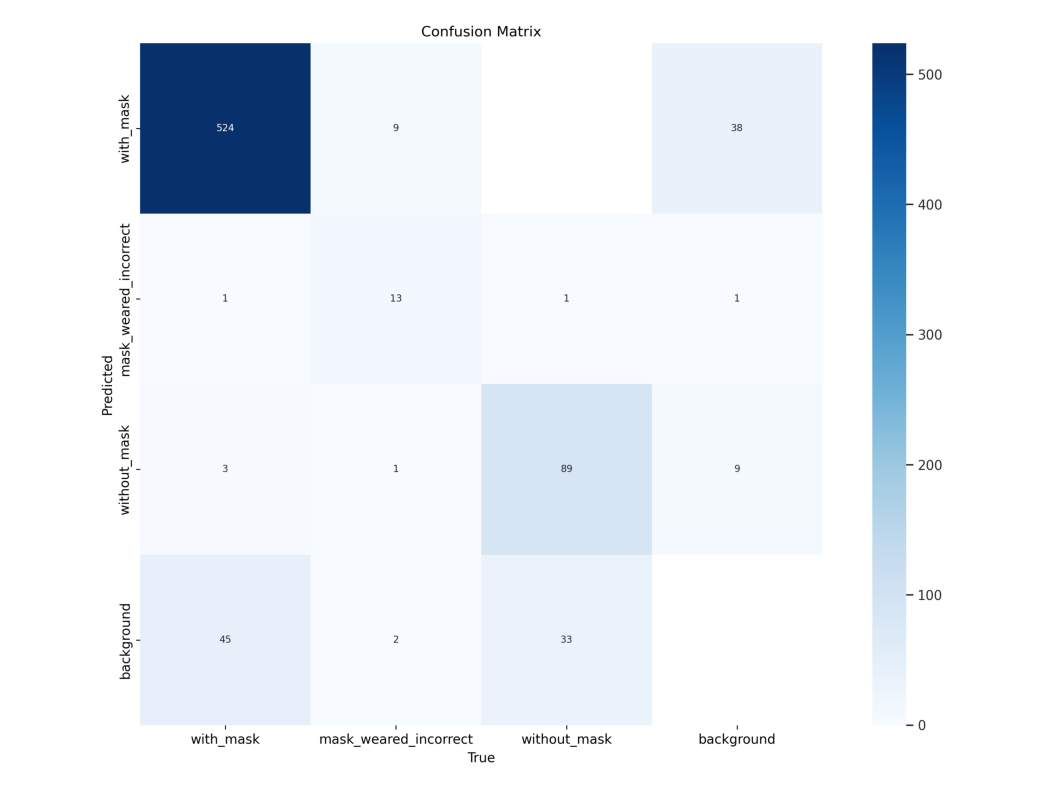

In [18]:
confusion_matrix = Image.open("/kaggle/working/runs/detect/train/confusion_matrix.png") # ตรง /kaggle/working/runs/detect/train อย่าลืมดูดีๆนะบางทีกด train 2 รอบ โมเดลปัจจุบันเราจะไปอยู่ folder train2 นะ
plt.figure(figsize=(20,10))
plt.imshow(confusion_matrix)
plt.axis(False)
plt.show()

# Model learning graph

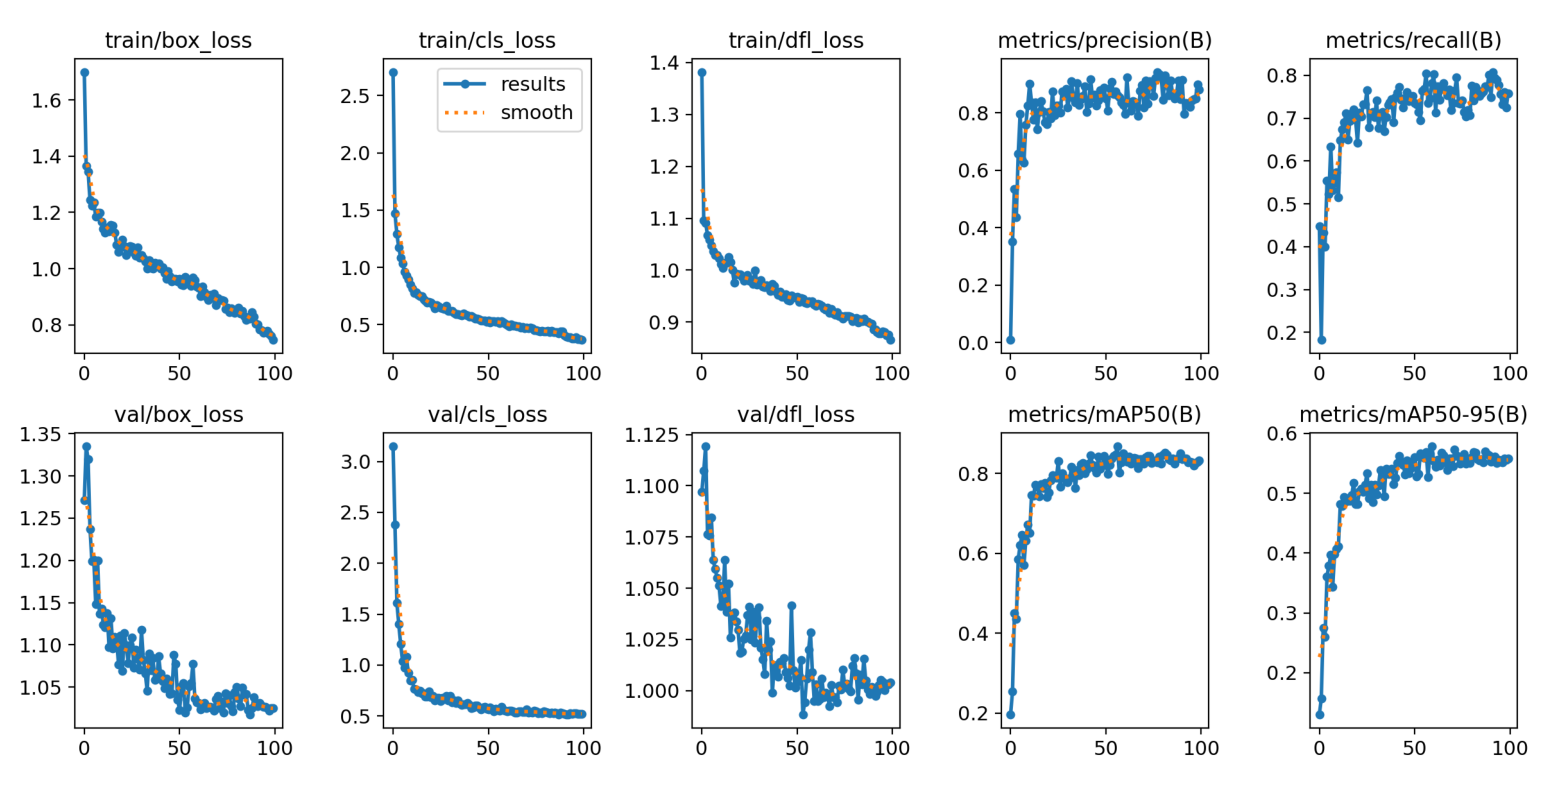

In [19]:
confusion_matrix = Image.open("/kaggle/working/runs/detect/train/results.png") # Don't forget to look at folder train as well.
plt.figure(figsize=(20,10))
plt.imshow(confusion_matrix)
plt.axis(False)
plt.show()

# Overall results

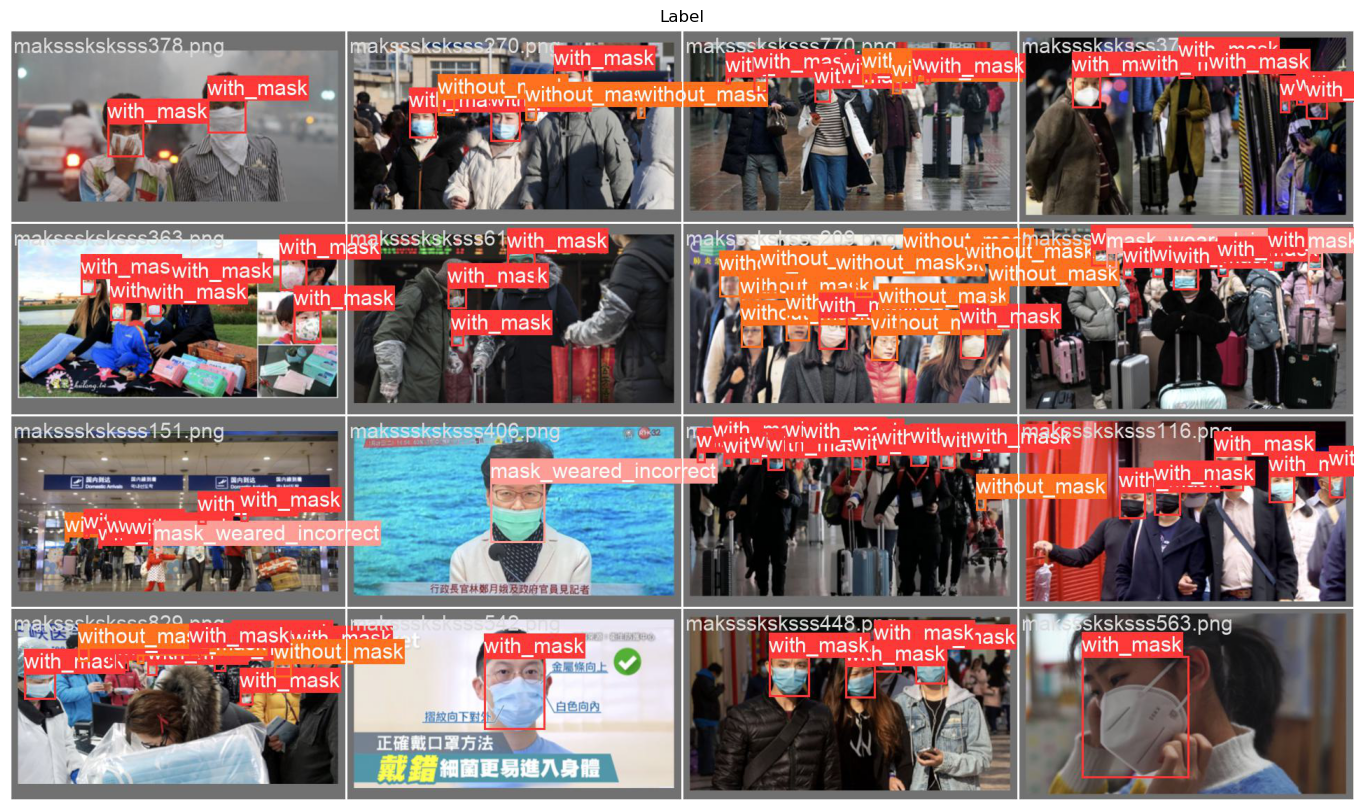

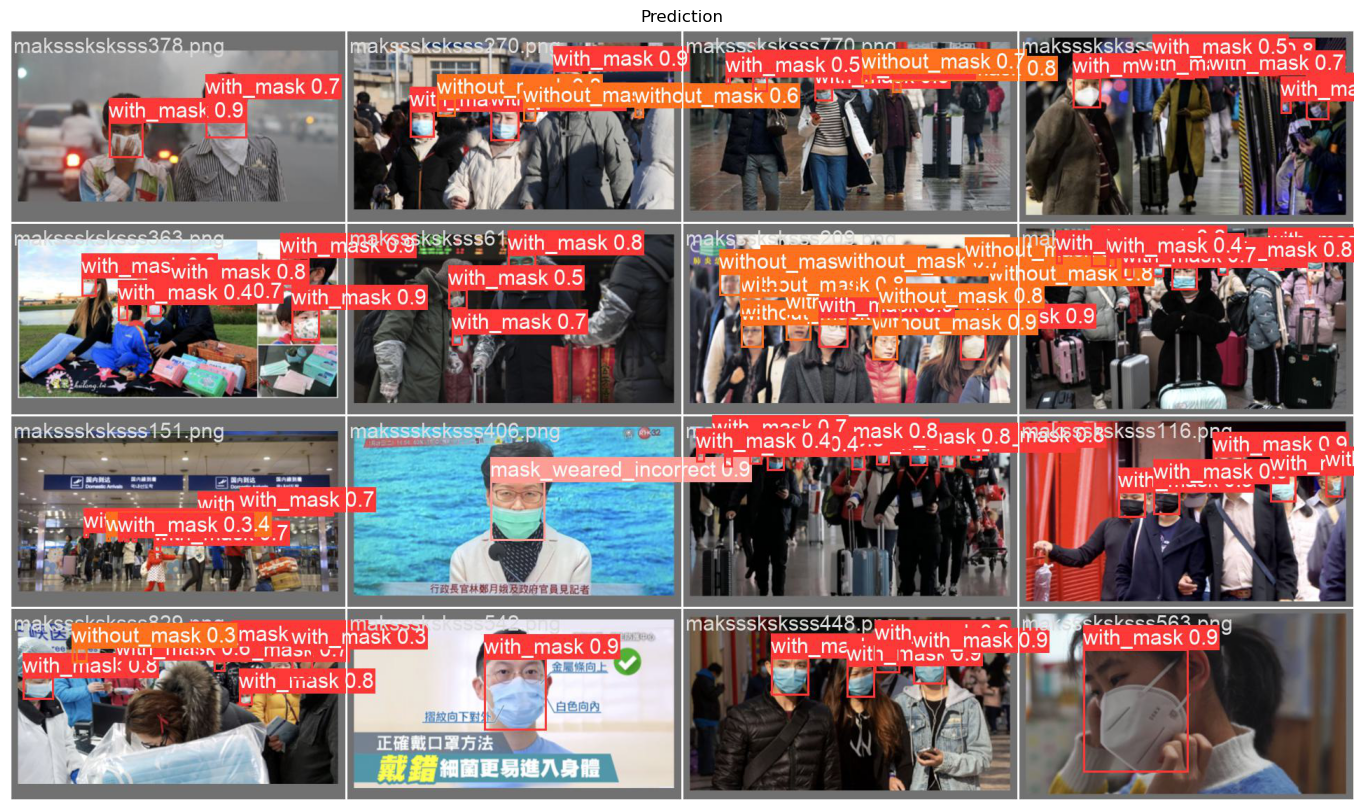

In [20]:
val_label = Image.open("/kaggle/working/runs/detect/train/val_batch0_labels.jpg") # อย่าลืมดู folder train ด้วย
val_pred = Image.open("/kaggle/working/runs/detect/train/val_batch0_pred.jpg") # อย่าลืมดู folder train ด้วย

plt.figure(figsize=(20,10))
plt.imshow(val_label)
plt.title("Label")
plt.axis(False)
plt.show()

plt.figure(figsize=(20,10))
plt.imshow(val_pred)
plt.title("Prediction")
plt.axis(False)
plt.show()

# Predict

In [21]:
model = YOLO(model="/kaggle/working/runs/detect/train/weights/best.pt") # Don't forget to look at folder train as well the path of best.pt model.

In [22]:
filenames = glob.glob(test_path+"/*.png", recursive=False)
test_image1 = cv2.imread(filenames[0])
test_image2 = cv2.imread(filenames[1])

results = model.predict([test_image1, test_image2], save=True, line_thickness=1)

WARNING ⚠️ 'line_thickness' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'line_width' instead.

0: 640x640 15 with_masks, 1: 640x640 2 with_masks, 24.4ms
Speed: 1.9ms preprocess, 12.2ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict


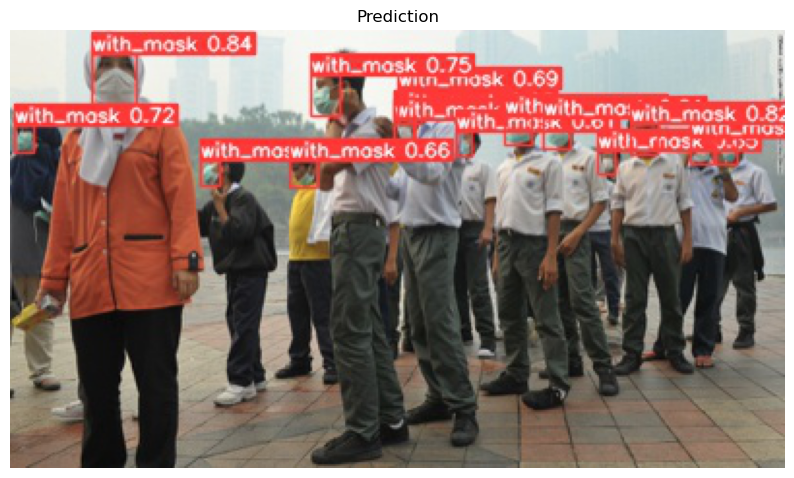

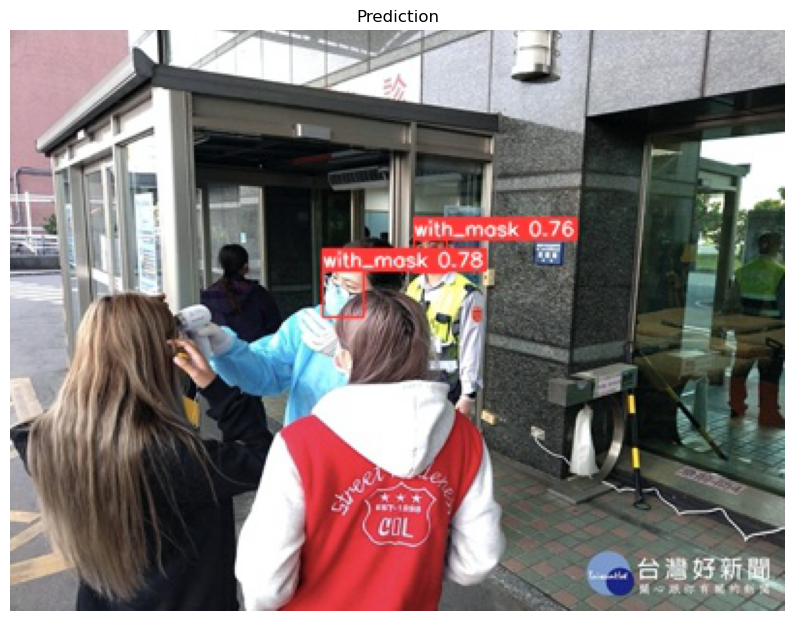

In [23]:
predicted_image = Image.open("runs/detect/predict/image0.jpg")
plt.figure(figsize=(10,10))
plt.imshow(predicted_image)
plt.title("Prediction")
plt.axis(False)
plt.show()

predicted_image = Image.open("runs/detect/predict/image1.jpg")
plt.figure(figsize=(10,10))
plt.imshow(predicted_image)
plt.title("Prediction")
plt.axis(False)
plt.show()